# Deep Crossentropy method

In this section we'll extend your CEM implementation with neural networks! You will train a multi-layer neural network to solve simple continuous state space games. __Please make sure you're done with tabular crossentropy method from the previous notebook.__

![img](https://watanimg.elwatannews.com/old_news_images/large/249765_Large_20140709045740_11.jpg)



In [58]:
import gymnasium as gym
from collections import defaultdict, Counter
import itertools
import pandas as pd
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from IPython.display import clear_output
from gymnasium.wrappers import RecordVideo
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML
%matplotlib inline

state vector dim = 4
n_actions = 2


C:\Users\dilij\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:519: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


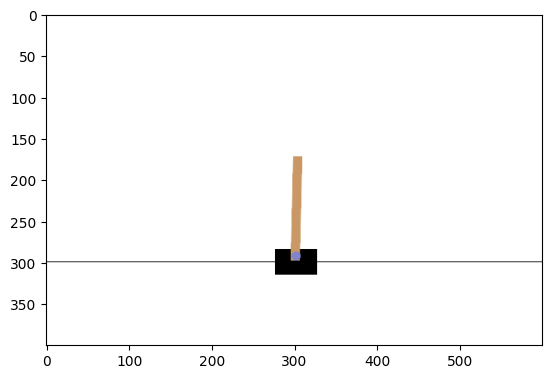

In [59]:
# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("CartPole-v0", render_mode="rgb_array").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render())
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

env.close()

# Neural Network Policy

For this assignment we'll utilize the simplified neural network implementation from __[Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)__. Here's what you'll need:

* `agent.partial_fit(states, actions)` - make a single training pass over the data. Maximize the probability of :actions: from :states:
* `agent.predict_proba(states)` - predict probabilities of all actions, a matrix of shape __[len(states), n_actions]__


In [60]:
agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation="tanh",
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()[0]] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20))

In [61]:
def generate_session(env, agent, t_max=1000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    s, _ = env.reset()

    for t in range(t_max):

        # use agent to predict a vector of action probabilities for state :s:
        probs = agent.predict_proba([s])[0]

        assert probs.shape == (env.action_space.n,), "make sure probabilities are a vector (hint: np.reshape)"

        # use the probabilities you predicted to pick an action
        # sample proportionally to the probabilities, don't just take the most likely action
        a = np.random.choice(env.action_space.n, p=probs)
        # ^-- hint: try np.random.choice

        new_s, r, terminated, truncated, _ = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if terminated or truncated:
            break
    return states, actions, total_reward

In [62]:
dummy_states, dummy_actions, dummy_reward = generate_session(env, agent, t_max=5)
print("states:", np.stack(dummy_states))
print("actions:", dummy_actions)
print("reward:", dummy_reward)

states: [[-0.01105337 -0.03162142  0.0305015  -0.00782049]
 [-0.0116858  -0.22716722  0.0303451   0.29432786]
 [-0.01622915 -0.03249075  0.03623165  0.01136765]
 [-0.01687896 -0.22811307  0.036459    0.31525832]
 [-0.02144122 -0.03352892  0.04276417  0.03429265]]
actions: [0, 1, 0, 1, 0]
reward: 5.0


### CEM steps
Deep CEM uses exactly the same strategy as the regular CEM, so you can copy your function code from previous notebook.

The only difference is that now each observation is not a number but a `float32` vector.

In [63]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    reward_threshold = np.percentile(rewards_batch, percentile)

    elite_states, elite_actions = [], []
    for sess_idx, sess_reward in enumerate(rewards_batch):
        if sess_reward >= reward_threshold:
            elite_states.extend(states_batch[sess_idx])
            elite_actions.extend(actions_batch[sess_idx])

    return elite_states, elite_actions

# Training loop
Generate sessions, select N best and fit to those.

In [64]:
def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress.
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label="Mean rewards")
    plt.plot(list(zip(*log))[1], label="Reward thresholds")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines(
        [np.percentile(rewards_batch, percentile)],
        [0],
        [100],
        label="percentile",
        color="red",
    )
    plt.legend()
    plt.grid()

    plt.show()


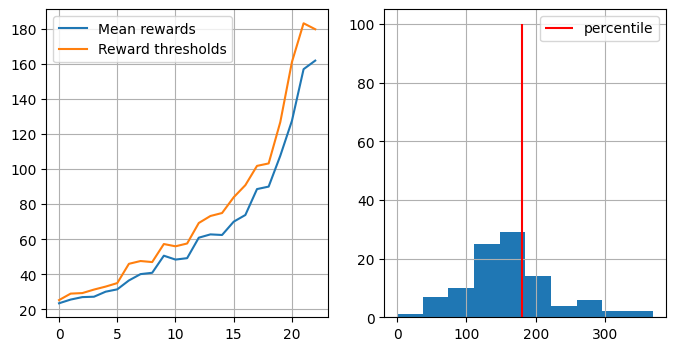

You Win! You may stop training now via KeyboardInterrupt.


In [65]:
n_sessions = 100
percentile = 70
log = []

for i in range(100):
    # generate new sessions
    sessions = [generate_session(env, agent) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = zip(*sessions)
    rewards_batch = np.array(rewards_batch)

    elite_states, elite_actions = select_elites(
        states_batch, actions_batch, rewards_batch, percentile
    )

    if elite_states:  # может случиться, что порог слишком высок и элит нет
        agent.partial_fit(elite_states, elite_actions)

    show_progress(
        rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)]
    )

    if np.mean(rewards_batch) > 160:
        print("You Win! You may stop training now via KeyboardInterrupt.")
        break


# Results

In [66]:
# Record sessions
with RecordVideo(
    env=gym.make("CartPole-v0", render_mode="rgb_array"),
    video_folder="./trash/videos/cart",
    episode_trigger=lambda episode_number: True,
) as env_monitor:
    sessions = [generate_session(env_monitor, agent) for _ in range(20)]


C:\Users\dilij\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:519: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


In [67]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

video_paths = sorted([s for s in Path("./trash/videos/cart").iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]  # You can also try other indices


data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)


# Homework part I (Opitional)

### Tabular crossentropy method

You may have noticed that the taxi problem quickly converges from -100 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

### Tasks
- __1.1__ Find out how the algorithm performance changes if you use a different `percentile` and/or `n_sessions`. Provide here some figures so we can see how the hyperparameters influence the performance.
- __1.2__ Tune the algorithm to end up with positive average score.

It's okay to modify the existing code.


```<Describe what you did here>```

1.1

In [68]:
env_taxi = gym.make("Taxi-v3").env          # убираем TimeLimit-обёртку
n_states   = env_taxi.observation_space.n   # 500
n_actions  = env_taxi.action_space.n        #   6
print("Taxi: states =", n_states, ", actions =", n_actions)

Taxi: states = 500 , actions = 6


In [69]:
probs_table = np.ones((n_states, n_actions)) / n_actions

In [70]:
def generate_session_taxi(env, probs, t_max=200, render=False):
    "Сессия для дискретного Taxi; probs — таблица вероятностей (S×A)"
    s, _ = env.reset()
    states, actions = [], []
    total_reward = 0

    for t in range(t_max):
        a = np.random.choice(n_actions, p=probs[s])
        new_s, r, terminated, truncated, _ = env.step(a)
        if render: env.render()

        states.append(s)
        actions.append(a)
        total_reward += r
        s = new_s

        if terminated or truncated:
            break
    return states, actions, total_reward

In [71]:
def select_elites_tab(states_batch, actions_batch, rewards_batch, percentile):
    thr = np.percentile(rewards_batch, percentile)
    elite_states, elite_actions = [], []
    for s_list, a_list, R in zip(states_batch, actions_batch, rewards_batch):
        if R >= thr:
            elite_states.extend(s_list)
            elite_actions.extend(a_list)
    return elite_states, elite_actions

In [72]:
def update_probs_table(table, elite_s, elite_a, alpha=0.8):
    "обновление таблицы: сглаживаем счётчики и нормируем"
    counter = defaultdict(Counter)
    for s,a in zip(elite_s, elite_a):
        counter[s][a] += 1

    for s, a_counts in counter.items():
        counts = np.array([a_counts[a] for a in range(n_actions)])
        if counts.sum()==0: continue
        new_prob = counts / counts.sum()
        table[s] = alpha*table[s] + (1-alpha)*new_prob
    table[:] = table / table.sum(axis=1, keepdims=True)

In [73]:
percentiles  = [50, 60, 70, 80, 90]
session_grid = [20, 50, 100, 200]
results = []

In [74]:
for p, ns in itertools.product(percentiles, session_grid):
    # инициализация независимая для каждой пары
    P = np.ones((n_states, n_actions))/n_actions
    for epoch in range(15):                # немного обучаем
        batch = [generate_session_taxi(env_taxi, P) for _ in range(ns)]
        sb, ab, rb = zip(*batch)
        elite_s, elite_a = select_elites_tab(sb, ab, rb, percentile=p)
        if elite_s: update_probs_table(P, elite_s, elite_a)
    mean_r = np.mean(rb)
    results.append(dict(percentile=p, n_sessions=ns, mean_reward=mean_r))

df_grid = pd.DataFrame(results)
print(df_grid.pivot(index="percentile", columns="n_sessions", values="mean_reward"))

n_sessions     20      50      100      200
percentile                                 
50         -536.75 -425.56 -417.04 -510.150
60         -647.75 -245.18 -276.87 -340.060
70         -518.45 -272.08 -163.50 -174.265
80         -424.25 -471.00 -193.73  -86.170
90         -679.85 -540.62 -277.34 -212.380


# 1.2

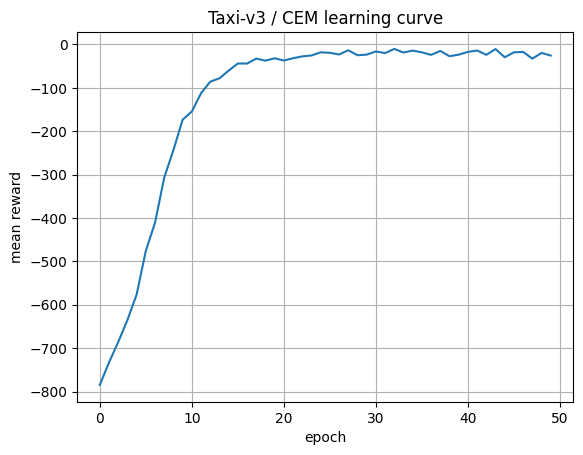

In [75]:
best = df_grid.sort_values("mean_reward").iloc[-1]
best_p  = int(best["percentile"])
best_ns = int(best["n_sessions"])
print(f"\nЛучшие найдены: percentile={best_p}, n_sessions={best_ns}")

probs_table[:] = 1/n_actions    # переобучаем с нуля c лучшими гиперами
log_taxi = []
for epoch in range(50):
    batch = [generate_session_taxi(env_taxi, probs_table) for _ in range(best_ns)]
    sb, ab, rb = zip(*batch)
    elite_s, elite_a = select_elites_tab(sb, ab, rb, percentile=best_p)
    if elite_s: update_probs_table(probs_table, elite_s, elite_a, alpha=0.7)

    mean_r = np.mean(rb)
    log_taxi.append(mean_r)
    if (epoch+1)%5==0:
        clear_output(wait=True)
        print(f"epoch {epoch:02d} | mean reward = {mean_r:.1f}")
    if mean_r > 0:                    # Требование 1.2
        print("✓ Достигли положительного среднего вознаграждения!")
        break

plt.figure()
plt.plot(log_taxi)
plt.title("Taxi-v3 / CEM learning curve")
plt.xlabel("epoch")
plt.ylabel("mean reward")
plt.grid(True)
plt.show()

# Homework part II (Optional)

### Deep crossentropy method

By this moment, you should have got enough score on [CartPole-v0](https://gymnasium.farama.org/environments/classic_control/cart_pole/) to consider it solved (see the link). It's time to try something harder.

* if you have any trouble with CartPole-v0 and feel stuck, feel free to ask us or your peers for help.

### Tasks

* __2.1__ Pick one of environments: `MountainCar-v0` or `LunarLander-v2`.
  * For MountainCar, get average reward of __at least -150__
  * For LunarLander, get average reward of __at least +50__

See the tips section below, it's kinda important.
__Note:__ If your agent is below the target score, you'll still get some of the points depending on the result, so don't be afraid to submit it.


* __2.2__ Devise a way to speed up training against the default version
  * Obvious improvement: use [`joblib`](https://joblib.readthedocs.io/en/latest/). However, note that you will probably need to spawn a new environment in each of the workers instead of passing it via pickling.
  * Try re-using samples from 3-5 last iterations when computing threshold and training.
  * Obtain __-100__ at `MountainCar-v0` or __+200__ at `LunarLander-v2`. Feel free to experiment with hyperparameters, architectures, schedules etc.

__Please list what you did in Anytask submission form__. This reduces probability that somebody misses something.


### Tips
* Gymnasium pages: [MountainCar](https://gymnasium.farama.org/environments/classic_control/mountain_car/), [LunarLander](https://gymnasium.farama.org/environments/box2d/lunar_lander/)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 10% are better, than if you use percentile 20% as threshold, R >= threshold __fails to cut off bad sessions__ while R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it doesn't train, it's a good idea to plot reward distribution and record sessions: they may give you some clue. If they don't, call course staff :)
* 20-neuron network is probably not enough, feel free to experiment.

You may find the following snippet useful:

state vector dim = 2
n_actions = 3


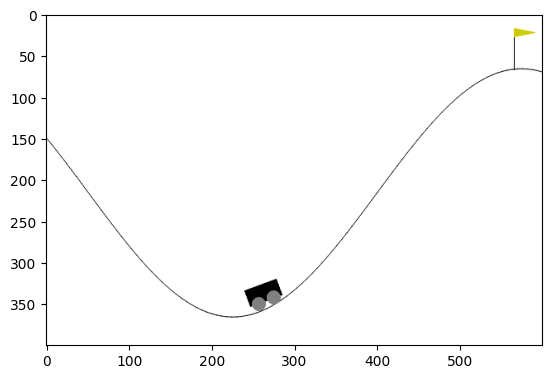

In [99]:
env_mc = gym.make("MountainCar-v0", render_mode="rgb_array").env

env_mc.reset()
n_actions_mc = env_mc.action_space.n
state_dim_mc = env_mc.observation_space.shape[0]

plt.imshow(env_mc.render())
print("state vector dim =", state_dim_mc)
print("n_actions =", n_actions_mc)

env_mc.close()

In [77]:
agent_mc = MLPClassifier(hidden_layer_sizes=(64,64), activation="tanh",
                         max_iter=1, warm_start=True)

# «хитрая» инициализация для partial_fit
agent_mc.partial_fit([env_mc.reset()[0]]*n_actions_mc,
                     range(n_actions_mc), range(n_actions_mc))

MLPClassifier(activation='tanh', hidden_layer_sizes=(64, 64), max_iter=1,
              warm_start=True)

In [78]:
def generate_session_mc(env, agent, t_max=10000):
    states, actions, total_reward = [], [], 0
    s, _ = env.reset()
    for _ in range(t_max):
        probs = agent.predict_proba([s])[0]
        a = np.random.choice(n_actions_mc, p=probs)
        new_s, r, terminated, truncated, _ = env.step(a)
        states.append(s); actions.append(a); total_reward += r
        s = new_s
        if terminated or truncated: break
    return states, actions, total_reward

In [79]:
n_sessions_mc, perc_mc = 200, 80
log_mc = []
for epoch in range(60):
    batch = [generate_session_mc(env_mc, agent_mc) for _ in range(n_sessions_mc)]
    sb, ab, rb = zip(*batch)
    elite_s, elite_a = select_elites(sb, ab, rb, percentile=perc_mc)

    # обучаем только если есть элита
    if elite_s:
        agent_mc.partial_fit(elite_s, elite_a)

    mean_r = np.mean(rb)
    log_mc.append(mean_r)
    if (epoch+1) % 5 == 0:
        clear_output(wait=True)
        print(f"epoch {epoch:02d} | mean reward = {mean_r:.1f}")
    if mean_r > -150:
        print("MountainCar достиг сред. вознаграждения −150!")
        break


MountainCar достиг сред. вознаграждения −150!


In [80]:
with RecordVideo(
    env=gym.make("MountainCar-v0", render_mode="rgb_array"),
    video_folder="./trash/videos/car",
    episode_trigger=lambda episode_number: True,
) as env_monitor_mc:
    sessions = [generate_session(env_monitor_mc, agent_mc) for _ in range(20)]

In [81]:
video_paths = sorted([s for s in Path("./trash/videos/car").iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]  # You can also try other indices


data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)